## 1.1 Loading Raw Datasets

In this cell, we load the three primary components of the Taobao ad dataset:  
- `raw_sample` (impression-level logs)  
- `ad_feature` (ad metadata)  
- `user_profile` (user demographics)

These datasets will later be merged to form a unified modelling dataframe.

In [77]:
import pandas as pd
# importing ad_features dataset
df_ad_feature = pd.read_csv("ad_feature.csv")
# importing raw_sample dataset
df_raw_sample = pd.read_csv("raw_sample.csv")
# importing user_profile dataset
df_user_profile = pd.read_csv("user_profile.csv")
# setting index of datasets to adgroup_id
df_ad_feature.set_index("adgroup_id", inplace = True)
df_ad_feature.sort_index(inplace = True)
df_raw_sample.set_index("adgroup_id", inplace = True)

# Basic info and shapes

print("raw_sample:", df_raw_sample.shape)
print(df_raw_sample.dtypes)

print("\nad_feature:", df_ad_feature.shape)
print(df_ad_feature.dtypes)

print("\nuser_profile:", df_user_profile.shape)
print(df_user_profile.dtypes)

raw_sample: (26557961, 5)
user           int64
time_stamp     int64
pid           object
nonclk         int64
clk            int64
dtype: object

ad_feature: (846811, 5)
cate_id          int64
campaign_id      int64
customer         int64
brand          float64
price          float64
dtype: object

user_profile: (1061768, 9)
userid                     int64
cms_segid                  int64
cms_group_id               int64
final_gender_code          int64
age_level                  int64
pvalue_level             float64
shopping_level             int64
occupation                 int64
new_user_class_level     float64
dtype: object


## 1.2 Merging the Raw Datasets

In this step, we combine the three source datasets into a single working dataframe:

1. **Merge `raw_sample` with `ad_feature`** using `adgroup_id`  
   This attaches ad-level metadata (category, campaign, customer, brand, price) to each impression.

2. **Rename `user` → `userid`**  
   This standardises naming and ensures compatibility with `user_profile`.

3. **Reindex on `userid` for efficient merging**  
   This prepares the dataset for user-level enrichment.

4. **Merge with `user_profile`** using `userid`  
   This adds demographic and behavioural attributes to each impression.

This merged dataframe forms the foundation for all subsequent preprocessing and feature engineering.

In [78]:
df = pd.merge(df_ad_feature,df_raw_sample,on = 'adgroup_id')
df.rename(columns = {"user": "userid"}, 
          inplace = True)
df.reset_index(inplace = True)
df.set_index("userid", inplace = True)
df = pd.merge(df,df_user_profile,on = 'userid')

df.head()

,userid,adgroup_id,cate_id,campaign_id,customer,brand,price,time_stamp,pid,nonclk,clk,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
0,581738,1,9025,108570,1337,20169.0,17.0,1494137644,430548_1007,1,0,0,8,1,2,NaN,3,0,NaN
1,59579,2,9092,149811,23890,429819.0,65.0,1494401618,430548_1007,1,0,83,11,1,5,2.0,1,0,NaN
2,981673,2,9092,149811,23890,429819.0,65.0,1494639837,430539_1007,1,0,19,3,2,3,2.0,3,0,2.0
3,528699,2,9092,149811,23890,429819.0,65.0,1494290333,430539_1007,1,0,0,6,2,6,NaN,3,0,2.0
4,1087544,2,9092,149811,23890,429819.0,65.0,1494637726,430539_1007,1,0,0,8,1,2,NaN,3,0,3.0


## 1.3 Creating the Target Variable and Extracting Time-Based Features

In this step, we complete two essential preprocessing actions:

1. **Forming the binary target variable (`click`)**  
   - The raw dataset stores impressions in terms of `clk` (clicked) and `nonclk` (not clicked).  
   - Since each row represents a *single impression*, we convert these into a single binary feature:  
     - `click = 1 - nonclk`  
   - The original columns `clk` and `nonclk` are then dropped.

2. **Converting timestamps and deriving temporal attributes**  
   - The `time_stamp` field is provided in UNIX seconds.  
   - We convert it into a proper `datetime` format and extract several temporal components that are often predictive in CTR models:  
     - `hour`, `minute`, `second`  
     - `day` of month  
     - `weekday` (0 = Monday, 6 = Sunday)  
     - `date` (YYYY-MM-DD)

These transformations prepare the dataset for both exploratory time-based analysis and later sequence-aware feature engineering.

In [79]:
# create a single column 'click'
df['click'] = 1 - df['nonclk']

# drop the old columns
df.drop(['clk', 'nonclk'], axis=1, inplace=True)

# Converting the timestamp to date and time

df['time_stamp'] = pd.to_datetime(df['time_stamp'], unit='s')

# Extracting useful time based features
df['hour'] = df['time_stamp'].dt.hour
df['day'] = df['time_stamp'].dt.day
df['weekday'] = df['time_stamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['date'] = df['time_stamp'].dt.date
df['minute'] = df['time_stamp'].dt.minute
df['second'] = df['time_stamp'].dt.second
df['time_stamp'].min(),df['time_stamp'].max()

(Timestamp('2017-05-05 16:00:00'), Timestamp('2017-05-13 15:59:46'))

## 1.4 Handling Missing Values

In this step, we identify and treat missing values across the merged dataset.  
A column-wise NaN summary is first generated to understand which attributes contain missing observations.

Because the dataset contains a mix of **ordinal**, **categorical**, and **continuous** fields, different imputation strategies are applied:

- **`pvalue_level`** (user consumption grade) is an *ordinal* variable.  
  It is imputed using its **mode**, preserving class proportions.

- **`brand`** is an *ad-level categorical identifier*.  
  Missing values are replaced with a sentinel value (**-1**) to indicate "unknown brand" without distorting the category space.

- **`new_user_class_level`** is another *ordinal tier-level attribute*.  
  It is also filled using the column **mode** to maintain the original distribution.

Additionally, a minor column-cleaning step is applied to correct a naming issue where  
`new_user_class_level` contained an unintended trailing space.

A final NaN check confirms that all missing values have been successfully resolved.

In [80]:
# Check which columns have NaN values
df.isnull().sum().sort_values(ascending=False)

pvalue_level             13024272
brand                     7802592
new_user_class_level      6696303
userid                          0
minute                          0
date                            0
weekday                         0
day                             0
hour                            0
click                           0
occupation                      0
shopping_level                  0
age_level                       0
adgroup_id                      0
final_gender_code               0
cms_group_id                    0
cms_segid                       0
pid                             0
time_stamp                      0
price                           0
customer                        0
campaign_id                     0
cate_id                         0
second                          0
dtype: int64

In [81]:
# Handling NaN values

# Filling missing pvalue_level (user consumption grade)
# Since it's ordinal (1=low, 2=mid, 3=high), filling with mode. Using mode[0] since because .mode() gives a Series, 
# but fillna() needs a single value.

df.fillna({'pvalue_level':df['pvalue_level'].mode()[0]}, inplace=True)

In [82]:
# Filling missing brand (categorical / ad-level feature)
# 'brand' is categorical, so fill with a placeholder (e.g. 'unknown')
# using a sentinel like -1 to indicate unknown brand
df.fillna({'brand':-1}, inplace=True)

#sanity check
df.isnull().sum().sort_values(ascending=False)

new_user_class_level     6696303
userid                         0
adgroup_id                     0
minute                         0
date                           0
weekday                        0
day                            0
hour                           0
click                          0
occupation                     0
shopping_level                 0
pvalue_level                   0
age_level                      0
final_gender_code              0
cms_group_id                   0
cms_segid                      0
pid                            0
time_stamp                     0
price                          0
brand                          0
customer                       0
campaign_id                    0
cate_id                        0
second                         0
dtype: int64

In [88]:
df.columns

Index(['userid', 'adgroup_id', 'cate_id', 'campaign_id', 'customer', 'brand',
       'price', 'time_stamp', 'pid', 'cms_segid', 'cms_group_id',
       'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level',
       'occupation', 'new_user_class_level ', 'click', 'hour', 'day',
       'weekday', 'date', 'minute', 'second'],
      dtype='object')

In [8]:
# renaming new_user_class_level column as it contained a space in the end
df.rename(columns = {'new_user_class_level ':'new_user_class_level'}, inplace = True)

In [9]:
# Filling missing new_user_class_level (ordinal city-level feature)
# 1 = low-tier city, 2 = mid, 3 = high-tier etc.
# Filling with mode to retain class distribution
df.fillna({'new_user_class_level':df['new_user_class_level'].mode()[0]}, inplace=True)

# sanity check
df.isnull().sum().sort_values(ascending=False)

userid                  0
adgroup_id              0
minute                  0
date                    0
weekday                 0
day                     0
hour                    0
click                   0
new_user_class_level    0
occupation              0
shopping_level          0
pvalue_level            0
age_level               0
final_gender_code       0
cms_group_id            0
cms_segid               0
pid                     0
time_stamp              0
price                   0
brand                   0
customer                0
campaign_id             0
cate_id                 0
second                  0
dtype: int64

## 1.5 Fixing Data Types

In this step, we correct the data types for several columns that are stored as numeric values but represent **categorical identities** rather than continuous quantities.

- **ID-based fields** such as `userid`, `adgroup_id`, `cate_id`, and `campaign_id` are converted to the `category` dtype because they serve as identifiers, not numeric variables.
- **Demographic attributes** (e.g., `cms_segid`, `age_level`, `shopping_level`) are also cast to categorical types to ensure they are treated appropriately during modelling and feature engineering.

Finally, the cleaned dataset resulting from Step 1 is saved to disk for checkpointing and reproducibility.

In [10]:
# Fix Data Types
# Some columns are numerically encoded but categorical in meaning

id_cols = ['userid', 'adgroup_id', 'cate_id', 'campaign_id',
           'customer', 'brand', 'pid']
df[id_cols] = df[id_cols].astype('category')

In [11]:
# user attributes and are ordinal/categorical, not continuous numbers
demo_cols = ['cms_segid', 'cms_group_id', 'final_gender_code',
             'age_level', 'pvalue_level', 'shopping_level',
             'occupation', 'new_user_class_level']
df[demo_cols] = df[demo_cols].astype('category')

In [12]:
# Saving the result of step 1
df.to_csv("resultOfStep1.csv")

# 2. Description of Dataset / Exploratory Data Analysis (EDA)

In this section, we explore the merged Taobao dataset to understand its structure,
target variable distribution and key patterns across user and ad
attributes. These insights inform the data preparation and modelling choices in later
sections (e.g., handling class imbalance, engineering temporal features and selecting
appropriate models).

## 2.1 Dataset Structure and Variable Types

We first examine the overall shape and data types of the merged impression-level
dataset to confirm that the merge in Section 1 behaved as expected and to understand
the mix of identifiers, user attributes, ad attributes, temporal fields and the target
variable.

In [13]:
# 2.1 DATASET STRUCTURE AND BASIC STATS

print("Merged shape:", df.shape)
print("\nColumn dtypes:")
print(df.dtypes)

print("\nInfo():")
df.info()

Merged shape: (25029435, 24)

Column dtypes:
userid                        category
adgroup_id                    category
cate_id                       category
campaign_id                   category
customer                      category
brand                         category
price                          float64
time_stamp              datetime64[ns]
pid                           category
cms_segid                     category
cms_group_id                  category
final_gender_code             category
age_level                     category
pvalue_level                  category
shopping_level                category
occupation                    category
new_user_class_level          category
click                            int64
hour                             int32
day                              int32
weekday                          int32
date                            object
minute                           int32
second                           int32
dtype: object

Info

## 2.2 Data Integrity and Consistency Checks

In this cell, we perform basic data quality checks on the merged dataset:

- **Duplicate detection**  
  - Count fully duplicated rows.  
  - Check for repeated impressions with the same `userid`–`adgroup_id`–`date` combination (potential logging issues).

- **Identifier validity**  
  - Inspect key ID-like columns (`userid`, `adgroup_id`, `cate_id`, `campaign_id`, `customer`, `brand`, `pid`) for any zero or missing values, which would indicate corrupted or incomplete records.

- **Categorical value sanity checks**  
  - Print the distribution of `final_gender_code`, `age_level`, and `shopping_level` to ensure they only take expected, documented codes.

- **Hierarchical ad consistency**  
  - For each `adgroup_id`, verify that it maps to exactly **one** `cate_id`, `campaign_id`, and `brand`.  
  - Any `adgroup_id` pointing to multiple categories/campaigns/brands would signal inconsistent joins or data errors.

These checks help us confirm that the merged dataset is structurally sound before moving into deeper exploratory analysis.

In [14]:
# Count duplicates
duplicates_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates_count}")

Total duplicate rows: 0


In [15]:
# verify there are no repeated impressions for the same user–ad–day combination
dupes_key = df.duplicated(subset=['userid', 'adgroup_id', 'date']).sum()
print(f"Duplicate user–ad–date combinations: {dupes_key}")

Duplicate user–ad–date combinations: 378330


In [16]:
# check for missing or invalid IDs - Identifiers such as userid, adgroup_id, cate_id, 
# campaign_id, customer, and brand should never be 0 or NaN.
id_cols = ['userid', 'adgroup_id', 'cate_id', 
           'campaign_id', 'customer', 'brand', 'pid']
for col in id_cols:
    zero_vals = (df[col] == 0).sum() if df[col].dtype != 'category' else 0
    missing_vals = df[col].isna().sum()
    print(f"{col}: zeros={zero_vals}, missing={missing_vals}")

userid: zeros=0, missing=0
adgroup_id: zeros=0, missing=0
cate_id: zeros=0, missing=0
campaign_id: zeros=0, missing=0
customer: zeros=0, missing=0
brand: zeros=0, missing=0
pid: zeros=0, missing=0


In [17]:
# Confirm Logical Value Ranges
print(df['final_gender_code'].value_counts())
print(df['age_level'].value_counts())
print(df['shopping_level'].value_counts())

final_gender_code
2    18148469
1     6880966
Name: count, dtype: int64
age_level
3    7573614
4    6406045
5    4652618
2    4567837
1    1379703
6     440429
0       9189
Name: count, dtype: int64
shopping_level
3    21316498
2     2594215
1     1118722
Name: count, dtype: int64


In [18]:
# Verify Consistency of Hierarchical Ad Relationships
# Each adgroup_id should map to exactly one cate_id, campaign_id, and brand.
for key_col in ['cate_id', 'campaign_id', 'brand']:
    dup = df.groupby('adgroup_id', observed = False)[key_col].nunique()
    inconsistent = (dup > 1).sum()
    print(f"adgroup_id → {key_col} inconsistencies:", inconsistent)

adgroup_id → cate_id inconsistencies: 0
adgroup_id → campaign_id inconsistencies: 0
adgroup_id → brand inconsistencies: 0


## 2.3 Target Variable: Click vs Non-click Distribution

In this step, we examine the distribution of the target variable `click`, which indicates
whether a user clicked an advertisement (`1`) or not (`0`).  
Understanding this distribution is essential because highly imbalanced classes can
significantly affect model training, optimisation strategies, evaluation metrics, and the
choice of resampling or weighting methods in later stages.

The following code:
- Computes raw frequency counts of click vs non-click impressions  
- Computes the percentage distribution to quantify class imbalance  
- Plots a simple bar chart for visual confirmation  
- Frees intermediate variables after use to conserve memory

Raw counts of click vs non-click:
 click
0    23744922
1     1284513
Name: count, dtype: int64

Percentage distribution (%):
 click
0    94.86799
1     5.13201
Name: proportion, dtype: float64


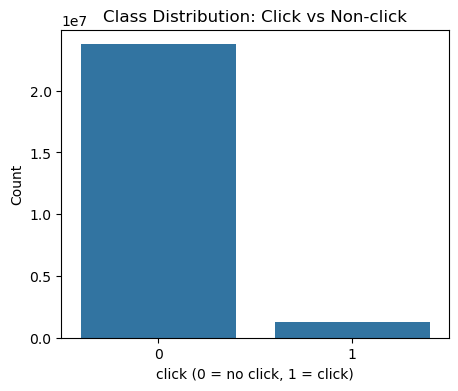

In [19]:
# TARGET CLASS DISTRIBUTION

click_counts = df['click'].value_counts()
click_rates = df['click'].value_counts(normalize=True) * 100

print("Raw counts of click vs non-click:\n", click_counts)
print("\nPercentage distribution (%):\n", click_rates)

# Simple bar plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.barplot(x=click_counts.index.astype(str), y=click_counts.values)
plt.title("Class Distribution: Click vs Non-click")
plt.xlabel("click (0 = no click, 1 = click)")
plt.ylabel("Count")
plt.show()
del click_counts,click_rates

## 2.4 CTR by atrributes

We next explore whether CTR varies across attributes like gender
(`final_gender_code`), age band (`age_level`) etc. This helps us assess whether
demographic segments exhibit different engagement behaviour and therefore carry
predictive signal.

### 2.4.1 CTR by Gender

This section examines how click-through rate varies by user gender.  
We first compute the mean click rate for each gender and then visualise the results through a simple bar plot.  
This helps identify whether male and female users exhibit different engagement behaviours with displayed ads.

  final_gender_code     click  Gender
0                 1  0.048354    Male
1                 2  0.052445  Female


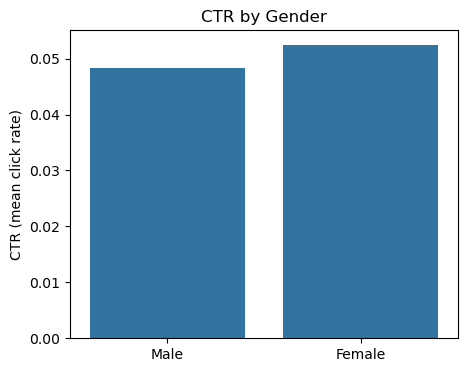

In [20]:
# CTR BY GENDER

gender_map = {1: 'Male', 2: 'Female'}

gender_ctr = (
    df.groupby('final_gender_code',observed = False)['click']
          .mean()
          .reset_index()
)
gender_ctr['Gender'] = gender_ctr['final_gender_code'].map(gender_map)

print(gender_ctr)

plt.figure(figsize=(5,4))
sns.barplot(data=gender_ctr, x='Gender', y='click')
plt.title("CTR by Gender")
plt.ylabel("CTR (mean click rate)")
plt.xlabel("")
plt.show()

### 2.4.2 Click-Through Rate (CTR) by Age Level

In this step, we analyse how CTR varies across different age groups.
The age_level attribute in the Taobao dataset encodes age brackets as:

We compute CTR for each group using the formula:

CTR = {Total Clicks}/{Total Impressions}


=== CTR BY AGE LEVEL ===
  age_level       CTR Age_Group
0         0  0.052454   Unknown
1         1  0.055237       ≤18
2         2  0.051737     19–24
3         3  0.051057     25–29
4         4  0.049540     30–34
5         5  0.052162     35–39
6         6  0.056218       ≥40


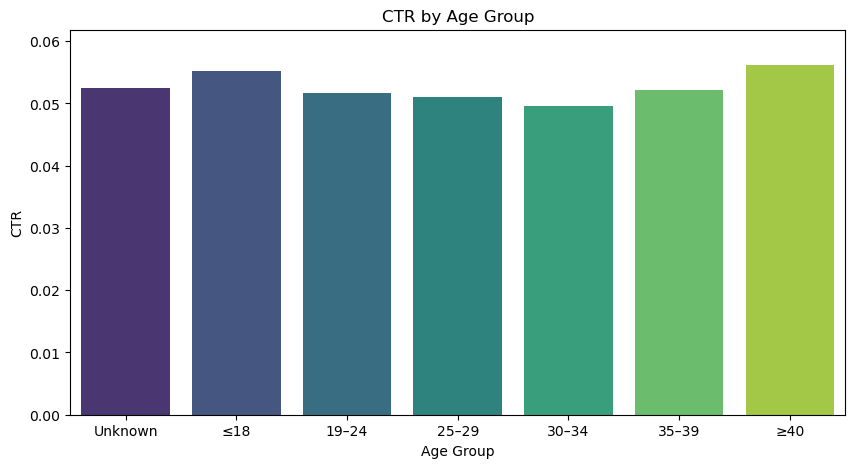

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# CTR by Age Level

# Age-level mapping for readability (for reporting)
age_map = {
    0: "Unknown",
    1: "≤18",
    2: "19–24",
    3: "25–29",
    4: "30–34",
    5: "35–39",
    6: "≥40"
}

# Compute CTR by age group
ctr_age = (
    df.groupby('age_level',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'CTR'})
)

# Add readable labels
ctr_age['Age_Group'] = ctr_age['age_level'].map(age_map)

print("=== CTR BY AGE LEVEL ===")
print(ctr_age)

# Bar Plot: CTR by Age Level

plt.figure(figsize=(10,5))
sns.barplot(
    data=ctr_age,
    x='Age_Group',
    y='CTR',
    hue='Age_Group',        # required to apply palette
    palette='viridis',
    legend=False            # hides redundant legend
)
plt.title("CTR by Age Group")
plt.xlabel("Age Group")
plt.ylabel("CTR")
plt.ylim(0, ctr_age['CTR'].max() * 1.1)
plt.show()

### 2.4.3 CTR by Consumption Grade (pvalue_level)

In this subsection, we analyse CTR across different consumer value segments
represented by **pvalue_level**, an ordinal attribute indicating a user’s purchasing
power or spending capacity.

The steps performed in this cell include:

- Mapping numeric `pvalue_level` values to readable labels  
  (**Low**, **Medium**, **High**) for interpretability.
- Computing the mean click-through rate (CTR) for each consumption grade.
- Visualising the CTR distribution through a bar chart.
- Dropping the temporary readable label column after plotting.

=== CTR BY CONSUMPTION GRADE ===
  pvalue_level Consumption_Grade       CTR
0          1.0               Low  0.051455
1          1.0            Medium       NaN
2          1.0              High       NaN
3          2.0               Low       NaN
4          2.0            Medium  0.051477
5          2.0              High       NaN
6          3.0               Low       NaN
7          3.0            Medium       NaN
8          3.0              High  0.047186


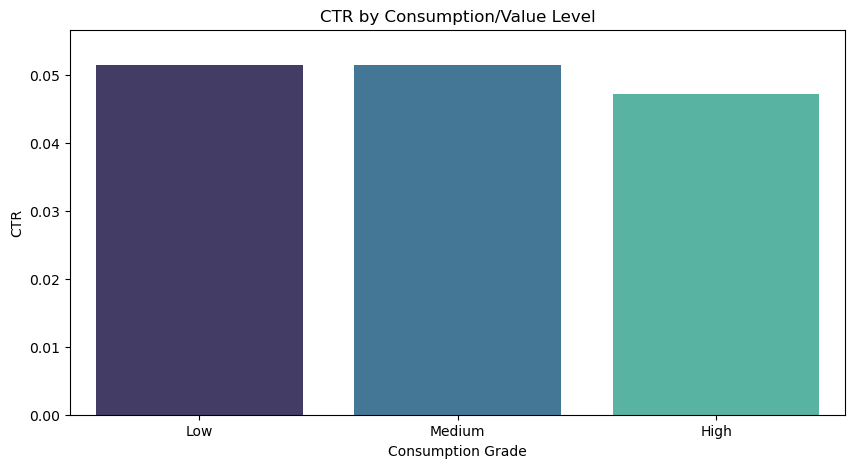

In [22]:
# ==== CTR BY CONSUMPTION GRADE (pvalue_level) ====

# Map consumption level to readable labels
pvalue_map = {
    1.0: "Low",
    2.0: "Medium",
    3.0: "High"
}

df['Consumption_Grade'] = df['pvalue_level'].map(pvalue_map)

# Compute CTR
ctr_pvalue = (
    df.groupby(['pvalue_level', 'Consumption_Grade'],observed = False)['click']
      .mean()
      .reset_index(name='CTR')
)

print("=== CTR BY CONSUMPTION GRADE ===")
print(ctr_pvalue)

# ---- Bar Plot ----
plt.figure(figsize=(10,5))
sns.barplot(
    data=ctr_pvalue,
    x='Consumption_Grade',
    y='CTR',
    hue='Consumption_Grade',
    palette='mako',
    legend=False
)
plt.title("CTR by Consumption/Value Level")
plt.xlabel("Consumption Grade")
plt.ylabel("CTR")
plt.ylim(0, ctr_pvalue['CTR'].max() * 1.1)
plt.show()
# dropping the temporary column
df.drop(["Consumption_Grade"], axis = 1, inplace = True)

### 2.4.4 CTR by Shopping Depth

This section examines how a user’s *shopping depth* influences their likelihood of clicking an ad.  
The variable `shopping_level` is an ordinal indicator of how deeply a user engages with the platform:

- **1 = Shallow user**  
- **2 = Moderate user**  
- **3 = Deep user**

The analysis computes the mean CTR for each group by grouping impressions by `shopping_level` and taking the average click rate. A bar chart is generated to visually compare click tendencies across the three segments.

=== CTR BY SHOPPING DEPTH ===
  shopping_level       CTR Shopping_Depth
0              1  0.053979        Shallow
1              2  0.051728       Moderate
2              3  0.051131           Deep


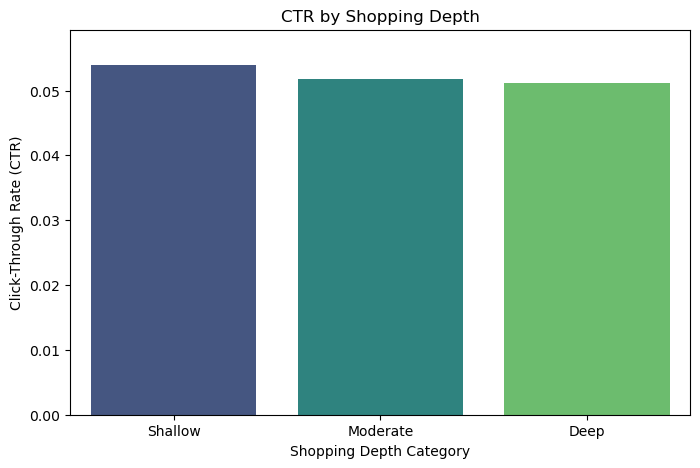

In [23]:
#  CTR by Shopping Depth


# Map shopping depth levels for clearer interpretation
shopping_map = {
    1.0: "Shallow",
    2.0: "Moderate",
    3.0: "Deep"
}

ctr_shop = (
    df.groupby('shopping_level',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'CTR'})
)

ctr_shop['Shopping_Depth'] = ctr_shop['shopping_level'].map(shopping_map)

print("=== CTR BY SHOPPING DEPTH ===")
print(ctr_shop)

# ----- Bar Plot -----
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(
    data=ctr_shop,
    x="Shopping_Depth",
    y="CTR",
    hue="Shopping_Depth",
    palette="viridis",
    legend=False
)
plt.title("CTR by Shopping Depth")
plt.xlabel("Shopping Depth Category")
plt.ylabel("Click-Through Rate (CTR)")
plt.ylim(0, ctr_shop['CTR'].max() * 1.1)
plt.show()

### 2.4.5 CTR by Occupation

This section examines whether a user’s occupation influences their likelihood of clicking an advertisement.  
The `occupation` attribute distinguishes **students** from **non-students**, enabling us to explore whether academic status correlates with engagement behaviour.

In this cell, we compute:

- The mean CTR for each occupation group  
- A readable mapping (`0 = Non-Student`, `1 = Student`)  
- A bar chart visualising CTR differences across groups

This helps reveal whether student users display different click tendencies compared with the general population.

=== CTR BY OCCUPATION ===
  occupation       CTR Occupation_Group
0          0  0.051309      Non-Student
1          1  0.051521          Student


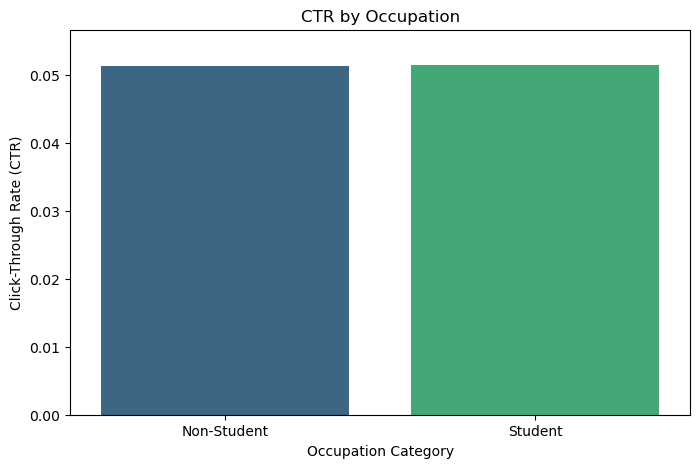

In [24]:
#    CTR by Occupation

# Mapping for readability:
occupation_map = {
    0.0: "Non-Student",
    1.0: "Student"
}

ctr_occ = (
    df.groupby('occupation',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'CTR'})
)

ctr_occ['Occupation_Group'] = ctr_occ['occupation'].map(occupation_map)

print("=== CTR BY OCCUPATION ===")
print(ctr_occ)

# ----- Bar Plot -----
plt.figure(figsize=(8,5))
sns.barplot(
    data=ctr_occ,
    x="Occupation_Group",
    y="CTR",
    hue="Occupation_Group",
    palette="viridis",
    legend=False
)
plt.title("CTR by Occupation")
plt.xlabel("Occupation Category")
plt.ylabel("Click-Through Rate (CTR)")
plt.ylim(0, ctr_occ['CTR'].max() * 1.1)
plt.show()

### 2.4.6 CTR by City Tier

This cell evaluates whether users from different city tiers exhibit differing click-through rates.  
The attribute `new_user_class_level` (1–4) represents the economic tier of the user’s city, where  
**Tier-1** cities are the most developed and **Tier-4+** the least developed.

We first compute mean CTR for each tier and then visualise the result using a bar chart.

=== CTR BY CITY TIER ===
  new_user_class_level       CTR City_Tier
0                  1.0  0.050427    Tier-1
1                  2.0  0.051715    Tier-2
2                  3.0  0.050602    Tier-3
3                  4.0  0.051089   Tier-4+


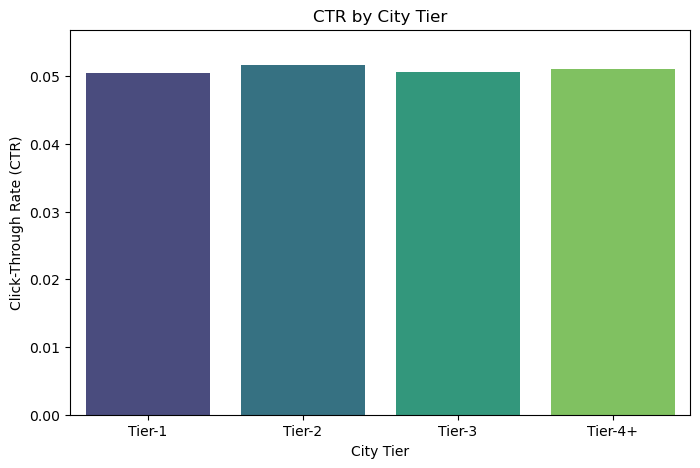

In [25]:

# CTR by City Tier

# Map city tiers for readability
city_map = {
    1.0: "Tier-1",
    2.0: "Tier-2",
    3.0: "Tier-3",
    4.0: "Tier-4+"
}

ctr_city = (
    df.groupby('new_user_class_level',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'CTR'})
)

ctr_city['City_Tier'] = ctr_city['new_user_class_level'].map(city_map)

print("=== CTR BY CITY TIER ===")
print(ctr_city)

# ----- Bar Plot -----
plt.figure(figsize=(8,5))
sns.barplot(
    data=ctr_city,
    x="City_Tier",
    y="CTR",
    hue="City_Tier",
    palette="viridis",
    legend=False
)
plt.title("CTR by City Tier")
plt.xlabel("City Tier")
plt.ylabel("Click-Through Rate (CTR)")
plt.ylim(0, ctr_city['CTR'].max() * 1.1)
plt.show()

### 2.4.7 CTR by PID (Scenario)

This subsection examines whether the *serving scenario* (PID) influences the likelihood of an ad being clicked.  
The Taobao dataset contains two PID identifiers, each representing a different page or display context.

We compute the mean click-through rate for each PID and visualise the results to determine whether scenario
type impacts user engagement.

Unique PID values: ['430548_1007', '430539_1007']
Categories (2, object): ['430539_1007', '430548_1007']

=== CTR BY PID (Scenario) ===
           pid       CTR    Scenario
0  430539_1007  0.053545  Scenario A
1  430548_1007  0.049910  Scenario B


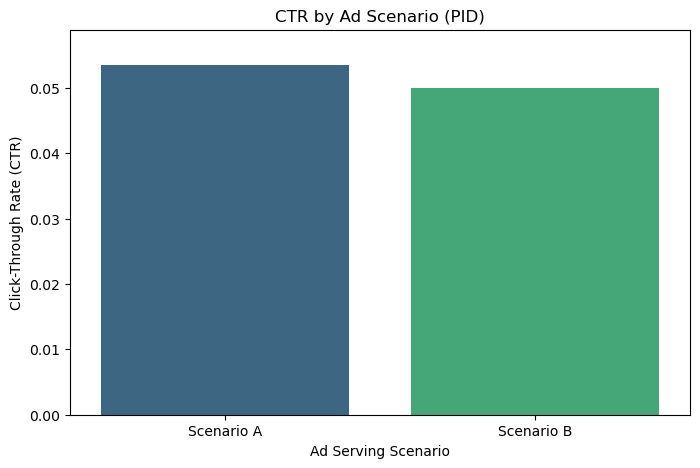

In [26]:
#   CTR by PID (Scenario)

# Let's inspect PID values for clarity
print("Unique PID values:", df['pid'].unique())

# Map for readability
pid_map = {
    '430539_1007': 'Scenario A',
    '430548_1007': 'Scenario B'
}

ctr_pid = (
    df.groupby('pid',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'CTR'})
)

ctr_pid['Scenario'] = ctr_pid['pid'].map(pid_map)

print("\n=== CTR BY PID (Scenario) ===")
print(ctr_pid)

# ----- Bar Plot -----
plt.figure(figsize=(8,5))
sns.barplot(
    data=ctr_pid,
    x="Scenario",
    y="CTR",
    hue="Scenario",
    palette="viridis",
    legend=False
)
plt.title("CTR by Ad Scenario (PID)")
plt.xlabel("Ad Serving Scenario")
plt.ylabel("Click-Through Rate (CTR)")
plt.ylim(0, ctr_pid['CTR'].max() * 1.1)
plt.show()

## 2.5 Price Distribution & Outlier Analysis

In this section, we explore the distribution of the price attribute to understand whether extreme values exist and how they may affect downstream modelling.

The initial histogram on a linear scale shows strong right-skewness, with most prices clustered near zero and a small set of extremely high values (e.g., 99,999,999). The log-scale histogram reveals the underlying structure more clearly by reducing compression near zero.

A boxplot further confirms the presence of extreme outliers.

We also compute price summary statistics and count the number of ads priced above 1,000,000, along with how many such records received clicks.

=== PRICE SUMMARY STATISTICS ===
count    2.502944e+07
mean     7.496794e+02
std      1.309436e+05
min      1.000000e-02
25%      8.700000e+01
50%      1.680000e+02
75%      3.280000e+02
max      1.000000e+08
Name: price, dtype: float64

=== TOP 10 HIGHEST PRICES ===
3897145    99999999.0
3897131    99999999.0
3897125    99999999.0
3897126    99999999.0
3897127    99999999.0
3897136    99999999.0
3897128    99999999.0
3897129    99999999.0
3897130    99999999.0
8369976    99999999.0
Name: price, dtype: float64


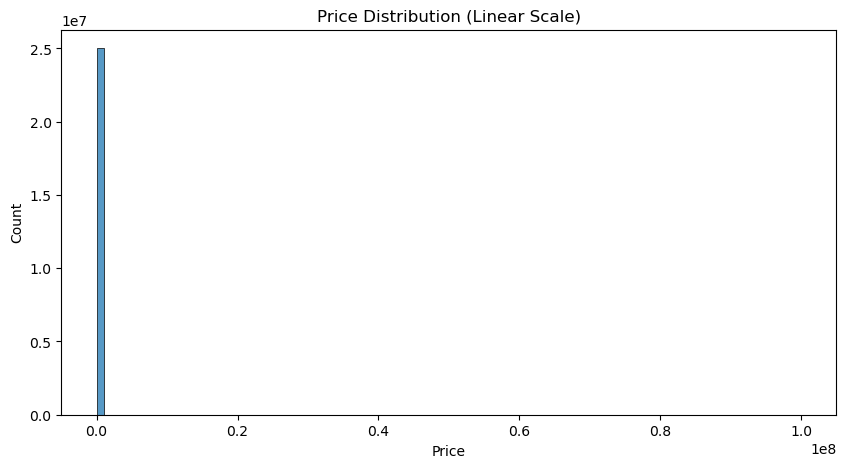

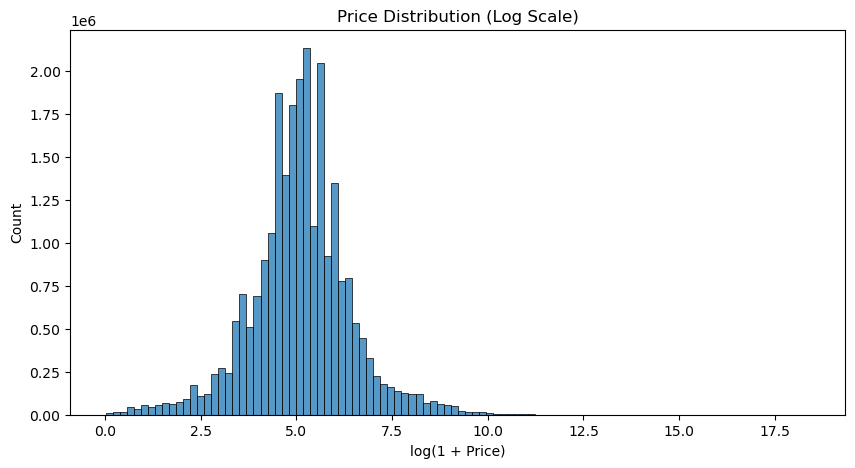

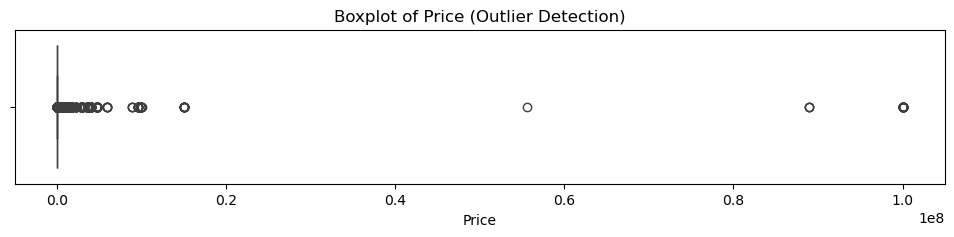


Number of price outliers > 1,000,000: 530
Number of clicked outliers > 1,000,000: 46


In [27]:

# PRICE DISTRIBUTION & OUTLIER ANALYSIS

import numpy as np

# ---- 1. Basic descriptive statistics for price ----
print("=== PRICE SUMMARY STATISTICS ===")
print(df['price'].describe())

# ---- 2. Check extreme values ----
print("\n=== TOP 10 HIGHEST PRICES ===")
print(df['price'].sort_values(ascending=False).head(10))

# ---- 3. Histogram of price (log scale to handle skew) ----
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=100, kde=False)
plt.title("Price Distribution (Linear Scale)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(np.log1p(df['price']), bins=100, kde=False)
plt.title("Price Distribution (Log Scale)")
plt.xlabel("log(1 + Price)")
plt.ylabel("Count")
plt.show()

# ---- 4. Boxplot to visualize outliers ----
plt.figure(figsize=(12,2))
sns.boxplot(df['price'], orient='h')
plt.title("Boxplot of Price (Outlier Detection)")
plt.xlabel("Price")
plt.show()

# ---- 5. Count extreme outliers ----
high_outliers = df[df['price'] > 1_000_000]   # 1M+ is visually extreme based on earlier inspection
print(f"\nNumber of price outliers > 1,000,000: {len(high_outliers)}")

# ---- 6. Check if outliers contain clicks ----
outlier_clicks = df[(df['price'] > 1_000_000) & (df['click'] == 1)]
print(f"Number of clicked outliers > 1,000,000: {len(outlier_clicks)}")

## 2.6 Pearson Correlation Analysis (Numerical Features)

We computed the Pearson correlation matrix across numerical attributes including price, brand, CMS segmentation variables, and all demographic encodings. This analysis helps identify linear dependencies and potential multicollinearity issues.

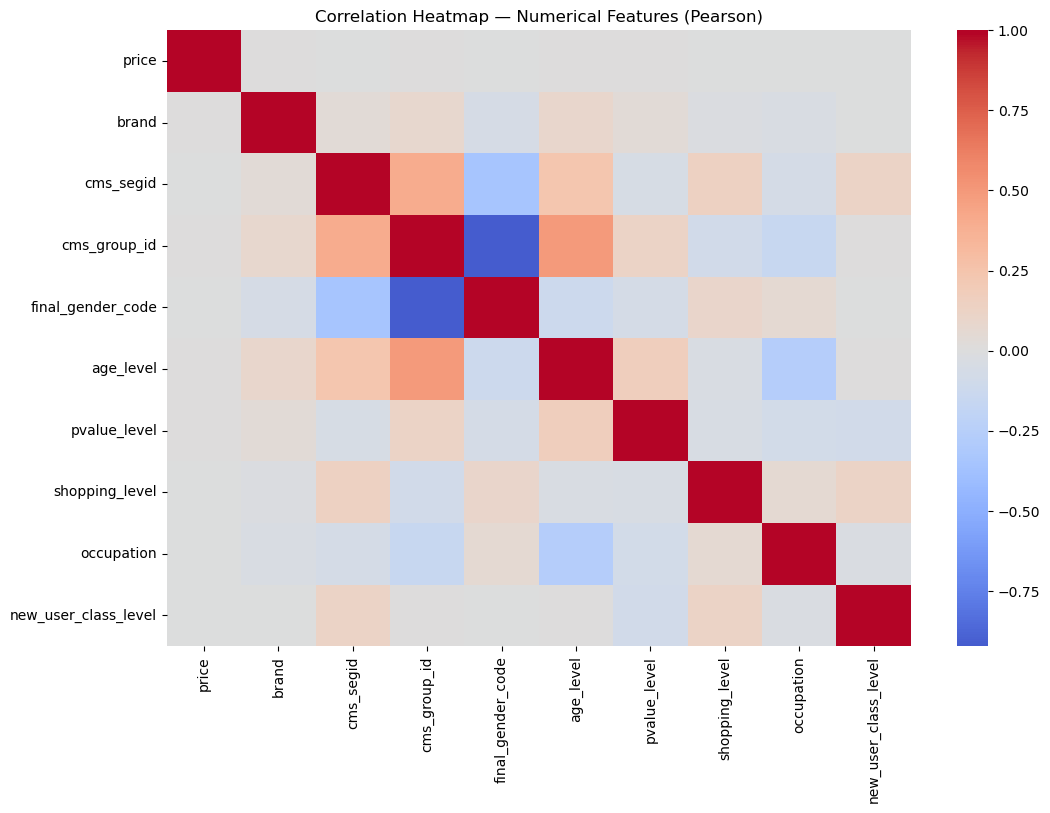

,price,brand,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
price,1.000000,0.002145,0.000888,0.002960,-0.002556,0.001865,0.001601,-0.000228,-0.000380,-0.000369
brand,0.002145,1.000000,0.032021,0.080836,-0.053386,0.087841,0.035318,-0.019476,-0.033343,-0.001236
cms_segid,0.000888,0.032021,1.000000,0.399747,-0.349498,0.241355,-0.043936,0.150015,-0.065591,0.114494
cms_group_id,0.002960,0.080836,0.399747,1.000000,-0.922075,0.496081,0.120403,-0.093411,-0.152007,0.002660
final_gender_code,-0.002556,-0.053386,-0.349498,-0.922075,1.000000,-0.122111,-0.061927,0.093304,0.054882,-0.001397
age_level,0.001865,0.087841,0.241355,0.496081,-0.122111,1.000000,0.170454,-0.030479,-0.267789,0.003584
pvalue_level,0.001601,0.035318,-0.043936,0.120403,-0.061927,0.170454,1.000000,-0.042866,-0.084784,-0.088988
shopping_level,-0.000228,-0.019476,0.150015,-0.093411,0.093304,-0.030479,-0.042866,1.000000,0.054051,0.115645
occupation,-0.000380,-0.033343,-0.065591,-0.152007,0.054882,-0.267789,-0.084784,0.054051,1.000000,-0.021330
new_user_class_level,-0.000369,-0.001236,0.114494,0.002660,-0.001397,0.003584,-0.088988,0.115645,-0.021330,1.000000


In [28]:
# === CORRELATION HEATMAP (NUMERIC FEATURES) ===

import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [
    'price', 'brand', 'cms_segid', 'cms_group_id',
    'final_gender_code', 'age_level', 'pvalue_level',
    'shopping_level', 'occupation', 'new_user_class_level'
]

plt.figure(figsize=(12, 8))
corr_matrix = df[numeric_cols].corr(method='pearson')

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap — Numerical Features (Pearson)")
plt.show()

corr_matrix

## 2.7. Spearman Correlation Analysis (Ordinal Features)

To better understand monotonic relationships across ordinal and categorical-encoded variables, we computed the Spearman rank-order correlation matrix for attributes including gender, age level, consumption grade, shopping depth, occupation, city tier, and CMS segmentation features.

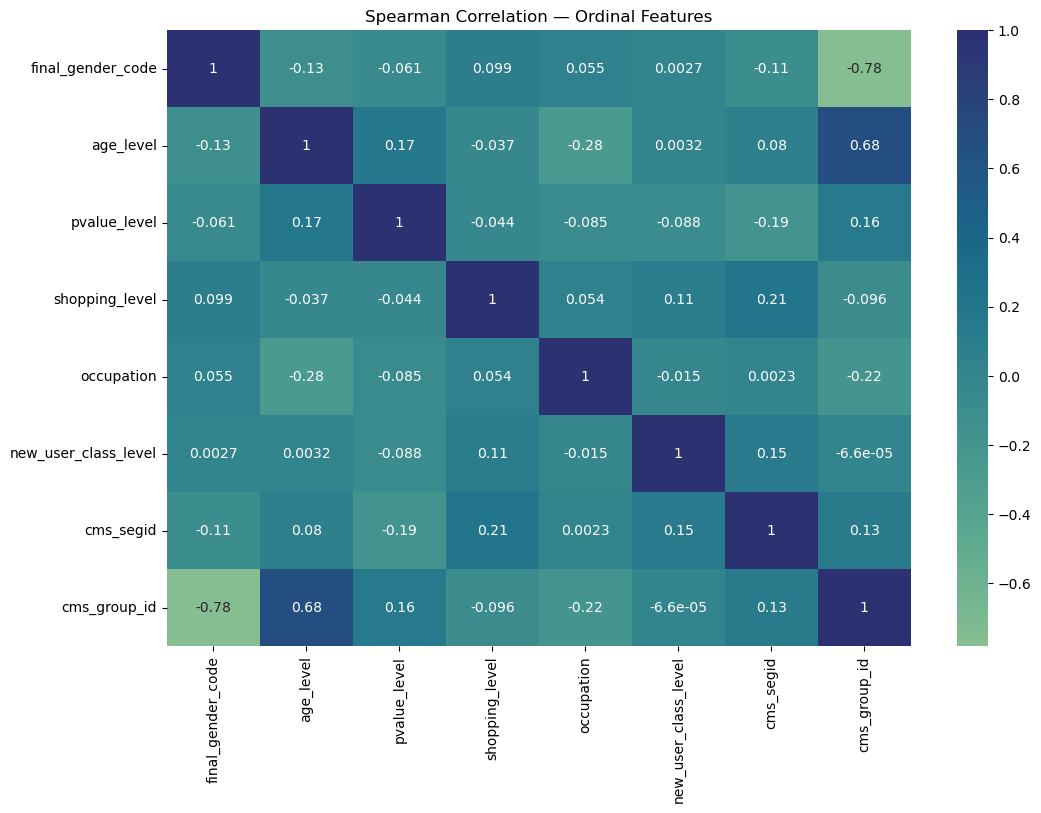

,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,cms_segid,cms_group_id
final_gender_code,1.000000,-0.125263,-0.061230,0.098661,0.054882,0.002706,-0.105513,-0.781828
age_level,-0.125263,1.000000,0.172919,-0.036767,-0.280644,0.003161,0.079712,0.684601
pvalue_level,-0.061230,0.172919,1.000000,-0.043538,-0.085398,-0.088465,-0.188809,0.157935
shopping_level,0.098661,-0.036767,-0.043538,1.000000,0.053850,0.114787,0.211496,-0.095853
occupation,0.054882,-0.280644,-0.085398,0.053850,1.000000,-0.015494,0.002271,-0.215216
new_user_class_level,0.002706,0.003161,-0.088465,0.114787,-0.015494,1.000000,0.150261,-0.000066
cms_segid,-0.105513,0.079712,-0.188809,0.211496,0.002271,0.150261,1.000000,0.129719
cms_group_id,-0.781828,0.684601,0.157935,-0.095853,-0.215216,-0.000066,0.129719,1.000000


In [29]:
# === 2.7.2 SPEARMAN CORRELATION FOR ORDINAL VARIABLES ===

ordinal_cols = [
    'final_gender_code',
    'age_level',
    'pvalue_level',
    'shopping_level',
    'occupation',
    'new_user_class_level',
    'cms_segid',
    'cms_group_id'
]

plt.figure(figsize=(12, 8))
corr_spearman = df[ordinal_cols].corr(method='spearman')

sns.heatmap(corr_spearman, annot=True, cmap='crest', center=0)
plt.title("Spearman Correlation — Ordinal Features")
plt.show()

corr_spearman

# 3. Initial Data Preparation

## 3.1 Feature Engineering: Time, User Behaviour, Ad Performance & Leakage-Free History

In this cell we construct the main **behavioural and contextual features** that will later drive our CTR prediction models:

- **Time-based context**
  - Derive `part_of_day` from `hour`  
    - `0 = night`, `1 = morning`, `2 = afternoon`, `3 = evening`.
  - Create `is_weekend` flag from `weekday`  
    - `1` if Saturday/Sunday, else `0`.

- **User-level behaviour (global aggregates)**
  - For each `userid`, compute:
    - `user_impressions` = total impressions.
    - `user_clicks` = total clicks.
    - `user_ctr` = `user_clicks / user_impressions`.
  - Compute `user_avg_ad_price` = mean `price` per user.

- **Sequential / recency features**
  - Build a proper `datetime` from `date + hour + minute + second`.
  - Sort by `userid, datetime` to respect chronological order.
  - For each user:
    - `user_impression_index` = 1st, 2nd, 3rd, … impression.
    - `secs_since_last_impression` = time gap (in seconds) since previous impression  
      (first impression gap is filled with the global median gap).

- **Ad / campaign / category / customer CTRs (global)**
  - Compute mean historical `click` rate for:
    - `adgroup_id` → `ad_ctr`
    - `cate_id` → `cate_ctr`
    - `brand` → `brand_ctr`
    - `campaign_id` → `campaign_ctr`
    - `customer` → `customer_ctr`
  - Merge these back to the main dataframe as contextual performance features.

- **Price binning**
  - Bucket `price` into `price_bin`:
    - `0` = ≤ 50 (low),
    - `1` = 51–200 (mid),
    - `2` = 201–1000 (high),
    - `3` = > 1000 (extreme / outlier ads).

- **Scenario encoding (PID)**
  - Encode the categorical `pid` (page/scenario) into a numeric `pid_enc`
    using `LabelEncoder`, preserving the original `pid` meaning but making it
    usable for ML algorithms.

- **User × Category personalisation**
  - For each `(userid, cate_id)` pair, compute:
    - `user_cate_ctr` = mean click rate of that user on that category.

- **Leakage-free user history features**
  - After re-sorting by `userid, datetime`:
    - `user_impressions_past` = number of **past** impressions for that user.
    - `user_clicks_past` = cumulative clicks up to the previous impression
      (never including the current row).
    - `user_ctr_past` = `user_clicks_past / user_impressions_past`  
      (with denominator protected against zero).
    - `user_avg_price_past` = expanding mean of `price` for each user,
      shifted by one row so it only reflects **past** exposures.

- **Drop non-model features / pure IDs**
  - Remove columns that either cause overfitting or are redundant after feature
    engineering:
    - `userid`, `adgroup_id`, `day`, `minute`, `second`,
      `time_stamp`, `datetime`, and raw `pid` (kept only as `pid_enc`).
  - Save the resulting feature-engineered dataset to  
    `"resultOfEngineeredFeatures_beforeSplit"` for reuse in later steps.

In [30]:
# Load the dataframe only when kernel dies down
import pandas as pd
import numpy as np

df = pd.read_csv("resultOfStep1.csv",index_col=0)

# Feature engineering steps
# 1. Part of day & weekend flag
# Part of day: 0=night, 1=morning, 2=afternoon, 3=evening
def get_part_of_day(h):
    if 6 <= h < 12:
        return 1  # morning
    elif 12 <= h < 18:
        return 2  # afternoon
    elif 18 <= h < 24:
        return 3  # evening
    else:
        return 0  # night

df['part_of_day'] = df['hour'].apply(get_part_of_day)

# Weekend flag: 1 if Saturday(5) or Sunday(6)
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

In [31]:
# Step 2 – User-level Features
# 2.1 Basic user impressions / clicks / CTR

user_stats = (
    df.groupby('userid',observed = False)['click']
      .agg(user_impressions='size', user_clicks='sum')
      .reset_index()
)

user_stats['user_ctr'] = user_stats['user_clicks'] / user_stats['user_impressions']

df = df.merge(user_stats, on='userid', how='left')

In [32]:
# 2.2 User-level average ad price exposure
user_price = (
    df.groupby('userid',observed = False)['price']
      .mean()
      .reset_index()
      .rename(columns={'price': 'user_avg_ad_price'})
)

df = df.merge(user_price, on='userid', how='left')

In [33]:
# 2.3 Sequence / recency features
# Sort by user and time

# make sure date is a proper string like '2017-05-06'
df['datetime'] = pd.to_datetime(
    df['date'].astype(str) + ' ' +
    df['hour'].astype(str) + ':' +
    df['minute'].astype(str) + ':' +
    df['second'].astype(str)
)
df = df.sort_values(['userid', 'datetime'])

# Impression index per user (1st, 2nd, 3rd… impression)
df['user_impression_index'] = df.groupby('userid',observed = False).cumcount() + 1

# Time since last impression for this user
df['prev_time'] = df.groupby('userid',observed = False)['datetime'].shift(1)
df['secs_since_last_impression'] = (
    df['datetime'] - df['prev_time']
).dt.total_seconds()

# Fill NaN for the first impression with median gap
median_gap = df['secs_since_last_impression'].median(skipna=True)
df['secs_since_last_impression'] = df['secs_since_last_impression'].fillna(median_gap)

# Drop helper column
df = df.drop(columns=['prev_time'])

In [34]:
# Step 3 – Ad-level Features (Ad, Category, Brand, Campaign)
# 3.1 Ad (adgroup_id) CTR
ad_ctr = (
    df.groupby('adgroup_id',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'ad_ctr'})
)

df = df.merge(ad_ctr, on='adgroup_id', how='left')

In [35]:
# 3.2 Category, brand, campaign, advertiser CTR
# Category CTR
cate_ctr = (
    df.groupby('cate_id',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'cate_ctr'})
)

# Brand CTR
brand_ctr = (
    df.groupby('brand',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'brand_ctr'})
)

# Campaign CTR
campaign_ctr = (
    df.groupby('campaign_id',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'campaign_ctr'})
)

# Advertiser CTR
customer_ctr = (
    df.groupby('customer',observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'customer_ctr'})
)

df = df.merge(cate_ctr, on='cate_id', how='left')
df = df.merge(brand_ctr, on='brand', how='left')
df = df.merge(campaign_ctr, on='campaign_id', how='left')
df = df.merge(customer_ctr, on='customer', how='left')

In [36]:
# 3.3 Price buckets (bins)
# Price bucket binning
def price_bucket(price):
    if price <= 50:
        return 0   # Low price ads
    elif price <= 200:
        return 1   # Mid price ads
    elif price <= 1000:
        return 2   # High price ads
    else:
        return 3   # Outliers, extreme price ads (99999999 etc.)

# Apply binning
df['price_bin'] = df['price'].apply(price_bucket)
df['price_bin'].value_counts()

price_bin
1    11237573
2     8337588
0     3891365
3     1562909
Name: count, dtype: int64

In [37]:
# 4. Feature engineering for pid (scenario)

from sklearn.preprocessing import LabelEncoder

pid_encoder = LabelEncoder()

# Ensure pid is string before encoding
df['pid'] = df['pid'].astype(str)

# Create numeric encoded version of pid
df['pid_enc'] = pid_encoder.fit_transform(df['pid'])

# check
print("Number of unique pid values:", df['pid'].nunique())
print("Example mapping (first 10 classes):")
for i, cls in enumerate(pid_encoder.classes_[:10]):
    print(i, "->", cls)

Number of unique pid values: 2
Example mapping (first 10 classes):
0 -> 430539_1007
1 -> 430548_1007


In [38]:
#  5. User × Category Preference (Personalization)
user_cate_ctr = (
    df.groupby(['userid', 'cate_id'],observed = False)['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'user_cate_ctr'})
)

df = df.merge(user_cate_ctr, on=['userid', 'cate_id'], how='left')

In [39]:
# 6. LEAKAGE-FREE USER FEATURES
# ---- 1. Sort chronologically ----
df = df.sort_values(['userid', 'datetime']).reset_index(drop=True)

# ---- 2. Safe user impressions (past only) ----
df['user_impressions_past'] = df.groupby('userid',observed = False).cumcount()

# ---- 3. Safe user clicks (past only) ----
df['user_clicks_past'] = df.groupby('userid',observed = False)['click'].cumsum() - df['click']
df['user_clicks_past'] = df['user_clicks_past'].clip(lower=0)

# ---- 4. Safe user CTR ----
df['user_ctr_past'] = df['user_clicks_past'] / df['user_impressions_past'].replace(0, 1)

# ---- 5. Safe user avg price (past only) ----
df['user_avg_price_past'] = (
    df.groupby('userid',observed = False)['price']
      .expanding()
      .mean()
      .reset_index(level=0, drop=True)
)

df['user_avg_price_past'] = (
    df.groupby('userid',observed = False)['user_avg_price_past'].shift(1)
)

df['user_avg_price_past'] = df['user_avg_price_past'].fillna(0)

In [40]:
#dropping the unnecessary columns
cols_to_drop = [
    'userid',          # pure ID (causes overfitting)
    'adgroup_id',      # pure ID (used ad_ctr instead)
    'day',             # no meaning for CTR
    'minute',          # too granular
    'second',          # too granular
    'time_stamp',       # redundant after datetime
    'datetime',         # raw datetime not needed for modeling
    'pid',              # already encoded to pid_enc
]
df = df.drop(columns=cols_to_drop)

# placing target variable 'click' as last column
target = df.pop('click')
df['click'] = target

In [41]:
df.to_csv("resultOfEngineeredFeatures_beforeSplit")

In [42]:
# import engineered dataset only when kernel dies down
import pandas as pd
import numpy as np
df = pd.read_csv("resultOfEngineeredFeatures_beforeSplit", index_col=0)


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25029435 entries, 0 to 25029434
Data columns (total 37 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   cate_id                     int64  
 1   campaign_id                 int64  
 2   customer                    int64  
 3   brand                       float64
 4   price                       float64
 5   cms_segid                   int64  
 6   cms_group_id                int64  
 7   final_gender_code           int64  
 8   age_level                   int64  
 9   pvalue_level                float64
 10  shopping_level              int64  
 11  occupation                  int64  
 12  new_user_class_level        float64
 13  hour                        int64  
 14  weekday                     int64  
 15  date                        object 
 16  part_of_day                 int64  
 17  is_weekend                  int64  
 18  user_impressions            int64  
 19  user_clicks             

## 3.2 Feature Selection and Correlation (Chi-Square Analysis)

This step performs **filter-based feature selection** using the Chi-Square (χ²) statistical test.  
Since CTR prediction is a **binary classification task** and most engineered features are **positive numeric values**, the χ² test helps quantify the strength of association between each predictor and the target (`click`).  
The procedure includes:

1. **Time-based split:**  
   Train = impressions before *13 May 2017*  
   Test  = impressions on *13 May 2017* (chronologically faithful).

2. **Preparing numerical feature matrices** and ensuring all values are non-negative (χ² requirement).

3. **Computing χ² scores for all features** (`k = 'all'`), sorting them, and visualising their relative predictive power using:  
   - A **scree plot**  
   - A **cumulative predictive strength curve**

These diagnostics guide the decision on how many top-K features to retain for downstream modelling.

In [44]:
# Feature Selection and Correlation

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Train = 2017-05-05 to 2017-05-12, Test = 2017-05-13
train_df = df[df['date'] < pd.to_datetime('2017-05-13')]
test_df  = df[df['date'] == pd.to_datetime('2017-05-13')]

# Drop 'date' now (not used as feature)
train_df = train_df.drop(columns=['date'])
test_df  = test_df.drop(columns=['date'])

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (22361424, 36)
Test shape: (2668011, 36)


In [45]:
# prepare X,y numeric matrix for chi2
from sklearn.feature_selection import SelectKBest, chi2

# Target
y_train = train_df['click'].values
y_test  = test_df['click'].values

# Features only
X_train_full = train_df.drop(columns=['click'])
X_test_full  = test_df.drop(columns=['click'])

# Only numeric columns (should be all except any leftover objects)
X_train_num = X_train_full.select_dtypes(exclude=['object'])
X_test_num  = X_test_full.select_dtypes(exclude=['object'])

print("Numeric feature columns used for chi2:")
print(X_train_num.columns.tolist())

Numeric feature columns used for chi2:
['cate_id', 'campaign_id', 'customer', 'brand', 'price', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level', 'occupation', 'new_user_class_level', 'hour', 'weekday', 'part_of_day', 'is_weekend', 'user_impressions', 'user_clicks', 'user_ctr', 'user_avg_ad_price', 'user_impression_index', 'secs_since_last_impression', 'ad_ctr', 'cate_ctr', 'brand_ctr', 'campaign_ctr', 'customer_ctr', 'price_bin', 'pid_enc', 'user_cate_ctr', 'user_impressions_past', 'user_clicks_past', 'user_ctr_past', 'user_avg_price_past']


In [46]:
# Check for negatives
min_vals = X_train_num.min()
neg_cols = min_vals[min_vals < 0].index.tolist()
print("Columns with negative values (if any):", neg_cols)

# Shift any negative columns
for col in neg_cols:
    shift = -min_vals[col]
    X_train_num[col] = X_train_num[col] + shift
    X_test_num[col]  = X_test_num[col]  + shift

Columns with negative values (if any): ['brand']


In [47]:
# k='all' so we get scores for every feature, then we decide K ourselves
selector_all = SelectKBest(score_func=chi2, k='all')
selector_all.fit(X_train_num, y_train)

chi2_scores = pd.Series(selector_all.scores_, index=X_train_num.columns)
chi2_scores_sorted = chi2_scores.sort_values(ascending=False)

print("Chi-square scores (sorted):")
print(chi2_scores_sorted)

Chi-square scores (sorted):
secs_since_last_impression    1.089505e+09
brand                         1.280423e+08
price                         7.795783e+07
customer                      3.514437e+07
campaign_id                   2.879376e+07
user_impressions              2.227379e+07
user_avg_price_past           1.342517e+07
user_impressions_past         1.199926e+07
user_impression_index         1.187295e+07
user_avg_ad_price             2.088814e+06
user_cate_ctr                 1.764646e+06
cate_id                       3.510752e+05
user_clicks                   2.460641e+05
user_ctr                      1.396727e+05
ad_ctr                        2.408113e+04
user_ctr_past                 2.243447e+04
cms_segid                     1.785554e+04
campaign_ctr                  9.605774e+03
customer_ctr                  4.871049e+03
price_bin                     3.129850e+03
cms_group_id                  2.637032e+03
brand_ctr                     1.018429e+03
pid_enc                   

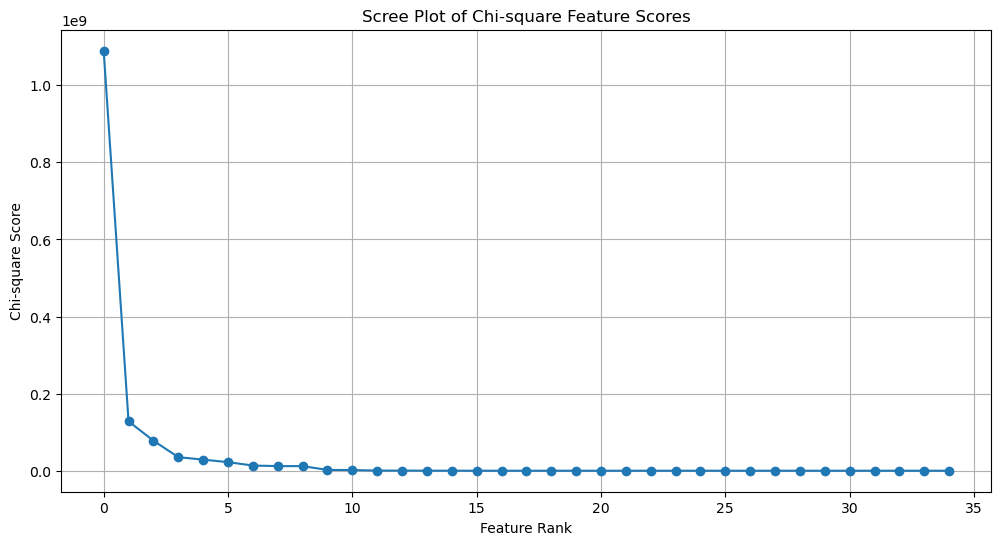

In [48]:
# top K value validation
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(len(chi2_scores_sorted)), chi2_scores_sorted.values, marker='o')
plt.title("Scree Plot of Chi-square Feature Scores")
plt.xlabel("Feature Rank")
plt.ylabel("Chi-square Score")
plt.grid(True)
plt.show()

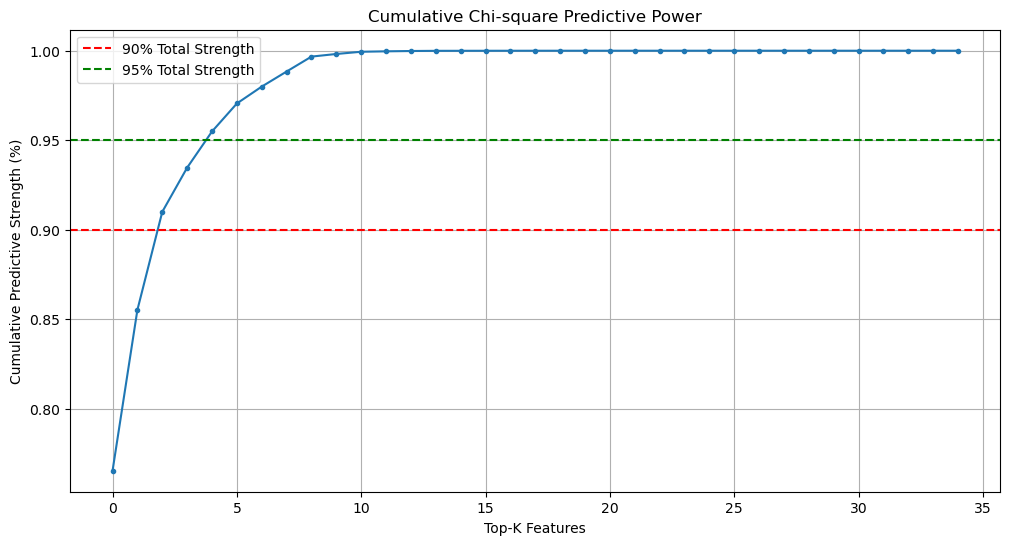

In [49]:
# Cumulative Percentage of Variance (Chi-Square Normalization)

cum_strength = np.cumsum(chi2_scores_sorted.values)
cum_strength = cum_strength / cum_strength[-1]  # normalize to % total strength

plt.figure(figsize=(12,6))
plt.plot(range(len(cum_strength)), cum_strength, marker='.')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Total Strength')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Total Strength')
plt.xlabel("Top-K Features")
plt.ylabel("Cumulative Predictive Strength (%)")
plt.title("Cumulative Chi-square Predictive Power")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Print cumulative percentages for easy decision-making
for k in [5, 10, 15, 20, 25, 30]:
    print(f"Top {k} features capture: {cum_strength[k-1]*100:.2f}% of total chi-square strength")

Top 5 features capture: 95.49% of total chi-square strength
Top 10 features capture: 99.82% of total chi-square strength
Top 15 features capture: 100.00% of total chi-square strength
Top 20 features capture: 100.00% of total chi-square strength
Top 25 features capture: 100.00% of total chi-square strength
Top 30 features capture: 100.00% of total chi-square strength


## 4.1 Baseline Model Benchmarking Using Top-20 Features  
In this step, we use the top-20 predictive features identified in the Chi-square analysis (cf. Notebook 3.2) to establish baseline model performance across a range of classical machine-learning algorithms.  
This provides a quantitative foundation for the iterative modelling process in later subsections.

In [51]:
# proceeding with the model training with top-20 features
# ===== 1. FINAL TOP-20 FEATURE LIST =====
top_20_features = [
    'secs_since_last_impression',
    'brand',
    'price',
    'customer',
    'campaign_id',
    'user_impressions',
    'user_avg_price_past',
    'user_impressions_past',
    'user_impression_index',
    'user_avg_ad_price',
    'user_cate_ctr',
    'cate_id',
    'user_clicks',
    'user_ctr',
    'ad_ctr',
    'user_ctr_past',
    'cms_segid',
    'campaign_ctr',
    'customer_ctr',
    'price_bin'
]


### 4.1.1 Preparing Train/Test Matrices with Top-20 Features  
We begin by extracting the 20 highest-scoring features and constructing the train/test matrices accordingly. To accommodate computational constraints for high-complexity estimators, reduced subsets of 500k (train) and 100k (test) rows are also created

In [52]:
# ===== BUILD TRAIN / TEST MATRICES =====
X_train = train_df[top_20_features].values
X_test  = test_df[top_20_features].values

y_train = train_df['click'].values
y_test  = test_df['click'].values

In [53]:
X_train.shape, y_train.shape

((22361424, 20), (22361424,))

In [54]:
# rebuilding small subsets for heavy models
import numpy as np

np.random.seed(42)  # for reproducibility

sample_size = 100_000      # adjust if needed
test_sample_size = 20_000   # adjust if needed

# Ensure sample sizes don’t exceed dataset size
sample_size = min(sample_size, len(X_train))
test_sample_size = min(test_sample_size, len(X_test))

train_idx = np.random.choice(len(X_train), size=sample_size, replace=False)
test_idx  = np.random.choice(len(X_test),  size=test_sample_size, replace=False)

X_train_small = X_train[train_idx]
y_train_small = y_train[train_idx]

X_test_small  = X_test[test_idx]
y_test_small  = y_test[test_idx]

### 4.1.2 Feature Scaling

All numerical features within the final top-20 selection were standardised using **z-score scaling**. The scaler was fitted on the training data and applied 

In [55]:
# ================================================================
# FEATURE SCALING
# ================================================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 4.1.3 Baseline Model Portfolio

To create a meaningful and diverse baseline, six commonly used supervised learning algorithms were selected:

- **Logistic Regression**  
- **Naive Bayes (Gaussian)**  
- **K-Nearest Neighbours (KNN)**  
- **Decision Tree Classifier**  
- **Support Vector Classifier (SVM)**  
- **Random Forest Classifier**

This model suite spans linear, probabilistic, non-parametric, margin-based, and ensemble methods, allowing broad insight into which modelling families naturally align with CTR patterns and the strong class imbalance.

In [56]:
# ================================================================
# IMPORT ALL MODELS
# ================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# ================================================================
# CREATE MODEL PIPELINE LIST
# ================================================================
modelPipelineList = []
modelPipelineList.append(("Logistic Regression", LogisticRegression()))
modelPipelineList.append(("Naive Bayes", GaussianNB()))
modelPipelineList.append(("KNN", KNeighborsClassifier()))
modelPipelineList.append(("Decision Tree", DecisionTreeClassifier()))
modelPipelineList.append(("SVM", SVC(probability=True)))
modelPipelineList.append(("Random Forest", RandomForestClassifier()))

### 4.1.4 Evaluation Metrics and running the benchmarks

Consistent evaluation across models was performed using:

- **Accuracy**  
- **Precision**  
- **Recall**  
- **F1-score**  
- **ROC-AUC**  
- **Confusion Matrix**

Given the highly imbalanced target (≈95% non-click), metrics such as precision, recall, F1-score, and ROC-AUC are more informative than accuracy alone. The confusion matrix provides granular visibility into false-positive and false-negative behaviour.
Each model in the pipeline was trained and evaluated using the metrics listed above. Heavy models were trained on the reduced subsets, while lightweight models were trained on the full training set. The resulting performance scores form the **baseline** against which all subsequent modelling decisions (hyperparameter tuning, sampling strategies, feature expansion/pruning, and advanced models) will be assessed in later iterations.

In [57]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

modellist             = []
accuracyList          = []
precisionList         = []
recallList            = []
f1List                = []
aucList               = []
confusionMatrixList   = []

for name, model in modelPipelineList:
    print(f"\nTraining {name} on top-20 features...")

    # Use smaller subset for heavy models
    if name in ["KNN", "SVM", "Random Forest"]:
        X_tr, y_tr = X_train_small, y_train_small
        X_te, y_te = X_test_small, y_test_small
        print(f"  -> Using reduced sample for {name}: "
              f"{X_tr.shape[0]} train rows, {X_te.shape[0]} test rows")
    else:
        X_tr, y_tr = X_train, y_train
        X_te, y_te = X_test, y_test

    # Fit model
    model.fit(X_tr, y_tr)

    # Predictions
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]   # needed for ROC-AUC

    # Metrics
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec  = recall_score(y_te, y_pred, zero_division=0)
    f1   = f1_score(y_te, y_pred, zero_division=0)
    roc  = roc_auc_score(y_te, y_prob)

    # Store for table
    modellist.append(name)
    accuracyList.append(acc)
    precisionList.append(prec)
    recallList.append(rec)
    f1List.append(f1)
    aucList.append(roc)
    confusionMatrixList.append(confusion_matrix(y_te, y_pred).tolist())

    # Console print
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print("Confusion Matrix:\n", confusionMatrixList[-1])


Training Logistic Regression on top-20 features...
Accuracy:  0.9587
Precision: 0.6562
Recall:    0.3735
F1-score:  0.4760
ROC-AUC:   0.9316
Confusion Matrix:
 [[2507841, 26215], [83922, 50033]]

Training Naive Bayes on top-20 features...
Accuracy:  0.9093
Precision: 0.2845
Recall:    0.5326
F1-score:  0.3709
ROC-AUC:   0.8080
Confusion Matrix:
 [[2354618, 179438], [62615, 71340]]

Training KNN on top-20 features...
  -> Using reduced sample for KNN: 100000 train rows, 20000 test rows
Accuracy:  0.9482
Precision: 0.1515
Recall:    0.0049
F1-score:  0.0096
ROC-AUC:   0.5185
Confusion Matrix:
 [[18959, 28], [1008, 5]]

Training Decision Tree on top-20 features...
Accuracy:  0.9452
Precision: 0.4583
Recall:    0.5084
F1-score:  0.4821
ROC-AUC:   0.7383
Confusion Matrix:
 [[2453573, 80483], [65854, 68101]]

Training SVM on top-20 features...
  -> Using reduced sample for SVM: 100000 train rows, 20000 test rows
Accuracy:  0.9494
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC

In [58]:
results_df = pd.DataFrame({
    'Model'           : modellist,
    'Accuracy'        : accuracyList,
    'Precision'       : precisionList,
    'Recall'          : recallList,
    'F1-score'        : f1List,
    'ROC-AUC'         : aucList,
    'Confusion Matrix': confusionMatrixList
})

results_df

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,Confusion Matrix
0,Logistic Regression,0.958719,0.656188,0.373506,0.476045,0.931633,"[[2507841, 26215], [83922, 50033]]"
1,Naive Bayes,0.909276,0.284475,0.532567,0.370855,0.808038,"[[2354618, 179438], [62615, 71340]]"
2,KNN,0.948200,0.151515,0.004936,0.009560,0.518528,"[[18959, 28], [1008, 5]]"
3,Decision Tree,0.945151,0.458333,0.508387,0.482064,0.738320,"[[2453573, 80483], [65854, 68101]]"
4,SVM,0.949350,0.000000,0.000000,0.000000,0.481138,"[[18987, 0], [1013, 0]]"
5,Random Forest,0.962350,0.809524,0.335637,0.474529,0.939709,"[[18907, 80], [673, 340]]"


## 4.2 Focused Training on Random Forest

This section documents the iterative tuning and optimisation of the Random Forest classifier, beginning with hyperparameter exploration on imbalanced data, followed by threshold tuning, class-balancing interventions, and full-scale training on the balanced dataset. Each step builds on insights gained from prior experiments, forming a structured iterative refinement process.

### 4.2.1 Random Forest Hyperparameter Tuning (Imbalanced Data)

In this step, we perform a RandomizedSearchCV over a wide parameter space to estimate a strong Random Forest configuration on the imbalanced training subset (`X_train_small`, `y_train_small`).  
The search optimises **F1-score**, addressing the strong class imbalance.  
The tuned estimator (`best_rf`) forms the basis for subsequent threshold tuning.

In [59]:
# proceeding with hyper-parameter tuning for Random forest
# Random Forest hyperparameter search with class balancing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
import numpy as np

# -------------------------------
# 1. Define RF + parameter space
# -------------------------------
rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

param_dist = {
    'n_estimators':      [200, 300, 400],
    'max_depth':         [20, 30, 40, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf':  [2, 4, 6, 8],
    'max_features':      ['sqrt', 'log2'],
    'bootstrap':         [True, False],
    'class_weight':      ['balanced']   # class balancing here
}

# ----------------------------------------
# 2. RandomizedSearchCV on SMALL TRAINING
# ----------------------------------------
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',          # optimise F1 directly
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print(">>> Running Random Forest hyperparameter search...")
rf_search.fit(X_train_small, y_train_small)

best_rf = rf_search.best_estimator_
print("\nBest RF parameters found:")
print(rf_search.best_params_)

>>> Running Random Forest hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best RF parameters found:
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 40, 'class_weight': 'balanced', 'bootstrap': True}


### 4.2.2 Classification Threshold Tuning for Random Forest

After hyperparameter tuning, we evaluate `best_rf` on the small test subset and sweep probability thresholds (0.05–0.50) to identify the operating point that maximises the F1-score.  
The chosen threshold provides insight into RF’s calibration behaviour under the original class imbalance.

In [60]:
# Threshold tuning for F1 (on small test set first)
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Predict probabilities on the small test set
y_proba_small = best_rf.predict_proba(X_test_small)[:, 1]

thresholds = np.arange(0.05, 0.91, 0.02)

best_t = 0.5
best_f1 = 0.0
best_prec = 0.0
best_rec = 0.0

for t in thresholds:
    y_pred_t = (y_proba_small >= t).astype(int)
    f1 = f1_score(y_test_small, y_pred_t, zero_division=0)
    prec = precision_score(y_test_small, y_pred_t, zero_division=0)
    rec = recall_score(y_test_small, y_pred_t, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_t = t
        best_prec = prec
        best_rec = rec

print(f"\nBest threshold on SMALL test set: {best_t:.2f}")
print(f"  F1 = {best_f1:.4f}, Precision = {best_prec:.4f}, Recall = {best_rec:.4f}")


Best threshold on SMALL test set: 0.49
  F1 = 0.5531, Precision = 0.5258, Recall = 0.5834


### 4.2.3 Creating a Balanced Training Set (Random Undersampling)

Since CTR prediction exhibits extreme class imbalance (~5% clicks), we next construct a balanced training dataset via random undersampling of the majority class (non-clicks).  
This produces `train_balanced`, which is then used to generate balanced feature matrices (`X_train_bal`, `y_train_bal`) for improved recall and F1-score.

In [61]:
# downsample majority class (noClick) to the size of minority (yesClick)
from sklearn.utils import resample

# 1. Check original class balance
print("Original train class counts:")
print(train_df['click'].value_counts())
print(train_df['click'].value_counts(normalize=True))

# 2. Split into majority (0) and minority (1)
majority = train_df[train_df['click'] == 0]   # no click
minority = train_df[train_df['click'] == 1]   # click

print("Majority (0):", len(majority))
print("Minority (1):", len(minority))

# 3. Downsample majority to match minority size (1:1 ratio)
majority_down = resample(
    majority,
    replace=False,                 # sample without replacement
    n_samples=len(minority),       # same size as minority
    random_state=42
)

print("Downsampled majority size:", len(majority_down))

# 4. Combine minority + downsampled majority
train_balanced = pd.concat([minority, majority_down], axis=0)

print("Balanced class counts:")
print(train_balanced['click'].value_counts())
print(train_balanced['click'].value_counts(normalize=True))

Original train class counts:
click
0    21210866
1     1150558
Name: count, dtype: int64
click
0    0.948547
1    0.051453
Name: proportion, dtype: float64
Majority (0): 21210866
Minority (1): 1150558
Downsampled majority size: 1150558
Balanced class counts:
click
1    1150558
0    1150558
Name: count, dtype: int64
click
1    0.5
0    0.5
Name: proportion, dtype: float64


In [62]:
train_balanced.to_csv("balancedClicks.csv")

In [63]:
import pandas as pd

# loading the balanced dataset
# train_balanced = pd.read_csv("balancedClicks.csv",index_col=0)
# Balanced training matrices
X_train_bal = train_balanced[top_20_features].values
y_train_bal = train_balanced['click'].values

X_test_raw = test_df[top_20_features].values
y_test_raw = test_df['click'].values
print(X_train_bal.shape), print(X_test_raw.shape)

(2301116, 20)
(2668011, 20)


(None, None)

### 4.2.4 Initial Random Forest on Balanced Small Subset

Here, a Random Forest (`rf_balanced_small`) is trained on the **balanced small subset**.  
Evaluation on a small test subset at the default threshold (0.5) provides the first indication of how balancing affects RF’s recall, precision, and F1-score.

In [64]:
# rebuilding small subsets for tuning
import numpy as np

np.random.seed(42)  # for reproducibility

sample_size = 100_000      # adjust if needed
test_sample_size = 20_000   # adjust if needed

# Ensure sample sizes don’t exceed dataset size
sample_size = min(sample_size, len(X_train_bal))
test_sample_size = min(test_sample_size, len(X_test_raw))

train_idx = np.random.choice(len(X_train_bal), size=sample_size, replace=False)
test_idx  = np.random.choice(len(X_test_raw),  size=test_sample_size, replace=False)

X_train_small = X_train_bal[train_idx]
y_train_small = y_train_bal[train_idx]

X_test_small  = X_test_raw[test_idx]
y_test_small  = y_test_raw[test_idx]

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

rf_balanced_small = RandomForestClassifier(
    n_estimators=400,
    max_depth=40,
    min_samples_split=10,
    min_samples_leaf=6,
    max_features='sqrt',
    class_weight=None,   # because we already balanced the training data
    n_jobs=-1,
    random_state=42
)


print("Fitting Random Forest on SMALL balanced train data...")
rf_balanced_small.fit(X_train_small, y_train_small)

# Predict probabilities and labels
y_proba_small = rf_balanced_small.predict_proba(X_test_small)[:, 1]
y_pred_small  = (y_proba_small >= 0.5).astype(int)

acc  = accuracy_score(y_test_small, y_pred_small)
prec = precision_score(y_test_small, y_pred_small, zero_division=0)
rec  = recall_score(y_test_small, y_pred_small, zero_division=0)
f1   = f1_score(y_test_small, y_pred_small, zero_division=0)
roc  = roc_auc_score(y_test_small, y_proba_small)
cm   = confusion_matrix(y_test_small, y_pred_small)

print("\n=== RF (small balanced train → small test, threshold=0.5) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print("Confusion Matrix:\n", cm)


Fitting Random Forest on SMALL balanced train data...

=== RF (small balanced train → small test, threshold=0.5) ===
Accuracy:  0.8300
Precision: 0.2180
Recall:    0.9289
F1-score:  0.3532
ROC-AUC:   0.9540
Confusion Matrix:
 [[15673  3328]
 [   71   928]]


### 4.2.5 Final Random Forest (Full Balanced Train + Tuned Threshold)

We tune thresholds again on the small test subset to find the optimal F1 cut-off, then train a full-scale Random Forest (`rf_final`) on the complete balanced training dataset.  
The final model is evaluated on the **full test day**, using the tuned threshold to maximise practical CTR-prediction performance.

In [66]:
thresholds = np.arange(0.05, 0.90, 0.01)

best_f1 = 0
best_t = 0

for t in thresholds:
    y_pred_t = (y_proba_small >= t).astype(int)
    f1_t = f1_score(y_test_small, y_pred_t, zero_division=0)
    if f1_t > best_f1:
        best_f1 = f1_t
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)

y_pred_best = (y_proba_small >= best_t).astype(int)

acc  = accuracy_score(y_test_small, y_pred_best)
prec = precision_score(y_test_small, y_pred_best, zero_division=0)
rec  = recall_score(y_test_small, y_pred_best, zero_division=0)
f1   = f1_score(y_test_small, y_pred_best, zero_division=0)
roc  = roc_auc_score(y_test_small, y_proba_small)
cm   = confusion_matrix(y_test_small, y_pred_best)

print("\n=== Tuned RF (threshold =", best_t, ") ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print("Confusion Matrix:\n", cm)

rf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight=None,
    n_jobs=-1,
    random_state=42
)

print("Training FINAL Random Forest on FULL balanced training set...")
rf_final.fit(X_train_bal, y_train_bal)

y_proba_full = rf_final.predict_proba(X_test_raw)[:, 1]
y_pred_full  = (y_proba_full >= best_t).astype(int)

acc  = accuracy_score(y_test_raw, y_pred_full)
prec = precision_score(y_test_raw, y_pred_full, zero_division=0)
rec  = recall_score(y_test_raw, y_pred_full, zero_division=0)
f1   = f1_score(y_test_raw, y_pred_full, zero_division=0)
roc  = roc_auc_score(y_test_raw, y_proba_full)
cm   = confusion_matrix(y_test_raw, y_pred_full)

print("\n=== FINAL RF (FULL test) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print("Confusion Matrix:\n", cm)

Best threshold: 0.8300000000000002
Best F1: 0.570497906002792

=== Tuned RF (threshold = 0.8300000000000002 ) ===
Accuracy:  0.9538
Precision: 0.5330
Recall:    0.6136
F1-score:  0.5705
ROC-AUC:   0.9540
Confusion Matrix:
 [[18464   537]
 [  386   613]]
Training FINAL Random Forest on FULL balanced training set...
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time= 2.0min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=20, n_estimators=300; total time= 1.2min
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=400; total time= 1.4min
[CV] END bootstrap=False, class_weight=ba

Exception ignored in: <function ResourceTracker.__del__ at 0x1075e2020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=  53.1s
[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=400; total time= 1.5min
[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 2.4min
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 1.1min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time= 1.0min


Exception ignored in: <function ResourceTracker.__del__ at 0x102a0a020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=400; total time= 1.4min
[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time= 1.2min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=400; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, class_weight

Exception ignored in: <function ResourceTracker.__del__ at 0x105f52020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time= 2.0min
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min
[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time= 1.2min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=400; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  37.7s


Exception ignored in: <function ResourceTracker.__del__ at 0x1052c2020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=  54.5s
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=400; total time= 1.4min
[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 2.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time=  55.4s


Exception ignored in: <function ResourceTracker.__del__ at 0x111912020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=  52.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 1.3min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=20, n_estimators=300; total time= 1.2min
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.3min
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 1.1min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, class_

Exception ignored in: <function ResourceTracker.__del__ at 0x110f7e020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time= 2.0min
[CV] END bootstrap=True, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=20, n_estimators=300; total time= 1.2min
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time= 1.2min
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time= 2.1min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time=  53.3s


Exception ignored in: <function ResourceTracker.__del__ at 0x10266a020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 2.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time= 1.4min
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 1.2min


Exception ignored in: <function ResourceTracker.__del__ at 0x110752020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.0min
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.2min
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time= 2.1min
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 1.2min


Exception ignored in: <function ResourceTracker.__del__ at 0x106efe020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END bootstrap=False, class_weight=balanced, max_depth=40, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 1.3min
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.0min
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.2min
[CV] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400; total time= 2.2min
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 1.2min


Exception ignored in: <function ResourceTracker.__del__ at 0x110e3a020>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



=== FINAL RF (FULL test) ===
Accuracy:  0.9587
Precision: 0.5771
Recall:    0.6678
F1-score:  0.6191
ROC-AUC:   0.9663
Confusion Matrix:
 [[2468498   65558]
 [  44501   89454]]


## 4.3 Experiments with Ensemble Models

Having optimised Random Forest, we extend experimentation to advanced ensemble methods—XGBoost and CatBoost—to examine whether gradient boosting architectures outperform RF on the CTR prediction task.  
These models are trained and evaluated on balanced datasets for consistent comparison.

### 4.3.1 XGBoost on Small Balanced Dataset

We train an XGBoost classifier on the small balanced dataset using standard boosting hyperparameters.  
This experiment provides a first comparison point against Random Forest in terms of F1, recall, and ROC-AUC.

In [67]:
# training xgboost
# installing xgboost
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print(">>> Running XGBoost on small balanced dataset...")

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# Train
xgb_model.fit(X_train_small, y_train_small)

# Predict
xgb_prob = xgb_model.predict_proba(X_test_small)[:, 1]
xgb_pred = (xgb_prob >= 0.5).astype(int)

# Metrics
acc  = accuracy_score(y_test_small, xgb_pred)
prec = precision_score(y_test_small, xgb_pred, zero_division=0)
rec  = recall_score(y_test_small, xgb_pred, zero_division=0)
f1   = f1_score(y_test_small, xgb_pred, zero_division=0)
roc  = roc_auc_score(y_test_small, xgb_prob)
cm   = confusion_matrix(y_test_small, xgb_pred)

print("\n=== XGBoost (small balanced train → small test) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print("Confusion Matrix:\n", cm)

>>> Running XGBoost on small balanced dataset...

=== XGBoost (small balanced train → small test) ===
Accuracy:  0.8560
Precision: 0.2462
Recall:    0.9129
F1-score:  0.3878
ROC-AUC:   0.9584
Confusion Matrix:
 [[16208  2793]
 [   87   912]]


### 4.3.2 CatBoost Baseline + Threshold Tuning

A baseline CatBoost classifier is trained on the small balanced dataset.  
We then perform a fine-grained threshold sweep (0.1–0.9) to identify the threshold that maximises the F1-score for CatBoost.  
This tuned threshold is later used for full-scale evaluation.

In [68]:
# installing and running catboost
!pip install catboost

from catboost import CatBoostClassifier

print(">>> Running CatBoost on small balanced dataset...")

cat_model = CatBoostClassifier(
    iterations=300,
    depth=8,
    learning_rate=0.1,
    loss_function='Logloss',
    random_seed=42,
    verbose=False
)

# Train
cat_model.fit(X_train_small, y_train_small)

# Predict
cat_prob = cat_model.predict_proba(X_test_small)[:, 1]
cat_pred = (cat_prob >= 0.5).astype(int)

# Metrics
acc  = accuracy_score(y_test_small, cat_pred)
prec = precision_score(y_test_small, cat_pred, zero_division=0)
rec  = recall_score(y_test_small, cat_pred, zero_division=0)
f1   = f1_score(y_test_small, cat_pred, zero_division=0)
roc  = roc_auc_score(y_test_small, cat_prob)
cm   = confusion_matrix(y_test_small, cat_pred)

print("\n=== CatBoost (small balanced train → small test) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print("Confusion Matrix:\n", cm)

>>> Running CatBoost on small balanced dataset...

=== CatBoost (small balanced train → small test) ===
Accuracy:  0.8553
Precision: 0.2458
Recall:    0.9169
F1-score:  0.3876
ROC-AUC:   0.9603
Confusion Matrix:
 [[16190  2811]
 [   83   916]]


### 4.3.3 CatBoost Hyperparameter Tuning + Final Model

We run RandomizedSearchCV on CatBoost to optimise depth, learning rate, regularisation, and border_count.  
The best configuration is then trained on the **full balanced training dataset** and evaluated on the **full test day**, using the threshold from Section 4.3.2.

In [69]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 100)
cat_f1_scores = []

for t in thresholds:
    preds = (cat_prob >= t).astype(int)
    cat_f1_scores.append(f1_score(y_test_small, preds))

best_t = thresholds[np.argmax(cat_f1_scores)]
best_f1 = max(cat_f1_scores)

print("Best threshold:", best_t)
print("Best F1:", best_f1)

Best threshold: 0.8595959595959596
Best F1: 0.5956834532374101


In [70]:
# hyper parameter tuning catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    verbose=False
)

param_dist = {
    'iterations':      [300, 500, 800],
    'depth':           [4, 6, 8, 10],
    'learning_rate':   [0.03, 0.05, 0.1],
    'l2_leaf_reg':     [1, 3, 5, 7, 9],
    'subsample':       [0.6, 0.8, 1.0],
    'border_count':    [64, 128, 254],  # more splits → better accuracy
}

cat_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

print(">>> Running CatBoost hyperparameter search...")
cat_search.fit(X_train_small, y_train_small)

best_cat = cat_search.best_estimator_
print("Best CatBoost parameters:")
print(cat_search.best_params_)

>>> Running CatBoost hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CatBoost parameters:
{'subsample': 1.0, 'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 300, 'depth': 6, 'border_count': 128}


In [71]:
from catboost import CatBoostClassifier

best_cat = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=9,
    subsample=1.0,
    border_count=128,
    loss_function='Logloss',
    random_state=42,
    verbose=False
)

print("Training final CatBoost on full balanced dataset...")
best_cat.fit(X_train_bal, y_train_bal)

Training final CatBoost on full balanced dataset...


In [72]:
cat_prob_full = best_cat.predict_proba(X_test_raw)[:, 1]

In [73]:
cat_pred_full = (cat_prob_full >= best_t).astype(int)

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

acc  = accuracy_score(y_test_raw, cat_pred_full)
prec = precision_score(y_test_raw, cat_pred_full)
rec  = recall_score(y_test_raw, cat_pred_full)
f1   = f1_score(y_test_raw, cat_pred_full)
roc  = roc_auc_score(y_test_raw, cat_prob_full)
cm   = confusion_matrix(y_test_raw, cat_pred_full)

print("\n=== FINAL CatBoost (FULL test) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")
print("Confusion Matrix:\n", cm)


=== FINAL CatBoost (FULL test) ===
Accuracy:  0.9631
Precision: 0.6347
Recall:    0.6237
F1-score:  0.6291
ROC-AUC:   0.9693
Confusion Matrix:
 [[2485966   48090]
 [  50411   83544]]


### 4.3.4 ROC Curve for CatBoost on Full Test Set  
To evaluate the discrimination ability of the tuned CatBoost classifier, we generated the Receiver Operating Characteristic (ROC) curve using predicted probabilities on the full unseen test dataset. The corresponding code is provided in the notebook.

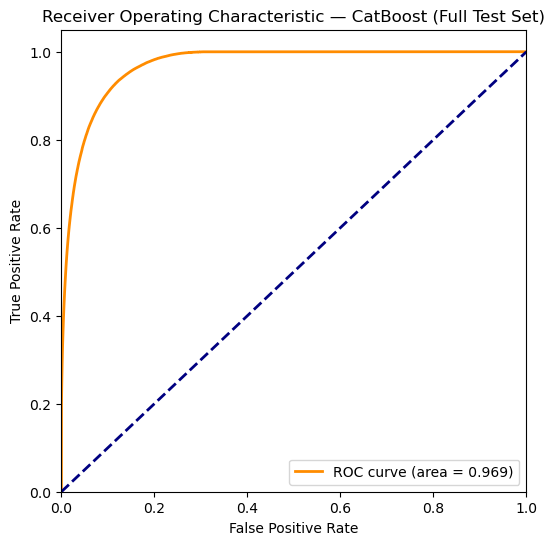

In [75]:
# ROC curve for CatBoost on FULL test set

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_test : true labels for FULL test set
# cat_prob_full : predicted probabilities from FINAL CatBoost on FULL test
#   cat_prob_full = best_cat.predict_proba(X_test_raw)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_raw, cat_prob_full)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(
    fpr,
    tpr,
    color='darkorange',
    lw=2,
    label=f'ROC curve (area = {roc_auc:.3f})'
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic — CatBoost (Full Test Set)')
plt.legend(loc="lower right")
plt.show()